In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)

import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed

import pyarrow as pa
import pyarrow.parquet as pq

##########################
# Then this stuff below allows us to make a nice inset


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#####################################################33
# on my laptop this issue arose and the suggested fix worked
# https://github.com/pyproj4/pyproj/issues/134

In [2]:
cwd = os.getcwd()

county_url = "https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip"
    
r = requests.get(county_url ) 

county_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

county_shapefile.extractall(path = cwd + "\\shapefiles\\county")

del r, county_shapefile

In [3]:
state_url = "https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip"
    
r = requests.get(state_url) 

state_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

state_shapefile.extractall(path = cwd + "\\shapefiles\\state")

del r, state_shapefile

In [3]:
file_path = os.getcwd()

trade_data = pq.read_table(file_path + "\\data\\total_trade_data.parquet").to_pandas()

trade_data["time"] = pd.to_datetime(trade_data.time)

trade_data.set_index(["area_fips", "time"],inplace = True)

In [4]:
trade_data["tariff_change"] = trade_data.groupby(["area_fips"]).tariff.diff(12)

trade_data.sort_values(["area_fips", "time"], inplace = True)

In [5]:
trade_data.head()

total_exp_pc  china_exp_pc    tariff  emplvl_2017  \
area_fips time                                                            
10001     2017-01-01    512.529185     53.382853  1.172229       2843.0   
          2017-02-01    492.604071     43.723710  1.172278       2843.0   
          2017-03-01    560.679984     37.347986  1.172365       2843.0   
          2017-04-01    499.471573     29.463467  1.172366       2843.0   
          2017-05-01    508.584288     30.009914  1.172366       2843.0   

                       fips  total_employment  tariff_change  
area_fips time                                                
10001     2017-01-01  10001           29514.0            NaN  
          2017-02-01  10001           29514.0            NaN  
          2017-03-01  10001           29514.0            NaN  
          2017-04-01  10001           29514.0            NaN  
          2017-05-01  10001           29514.0            NaN

In [19]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\county\\tl_2017_us_county.shx"

us_map = gpd.read_file(county_shape)

us_map = us_map.to_crs({'init': 'epsg:3395'})

In [20]:
us_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,POLYGON ((-10800163.11812986 5132991.983053582...
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-13740876.52543789 5787729.82287615,..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,POLYGON ((-11640388.27442317 4004583.794358812...
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,POLYGON ((-10788038.53315113 4978192.963294434...
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,POLYGON ((-10939774.56882773 4851419.990907463...


In [21]:
us_map["area_fips"] = (us_map.STATEFP.astype(str) + us_map.COUNTYFP.astype(str)).astype(int)

In [22]:
tariff_df = trade_data.xs('2018-12-1', level=1).copy()

tariff_df["fips_code"] = tariff_df.index

tariff_df["fips_code"] = tariff_df["fips_code"].astype(int)

In [23]:
tariff_df.head()

,total_exp_pc,china_exp_pc,tariff,emplvl_2017,fips,total_employment,tariff_change,fips_code
area_fips,,,,,,,,
10001,518.410176,21.394456,2.851468,2843.0,10001,29514.0,1.679103,10001
10003,498.999865,39.909067,0.447702,9072.0,10003,249775.0,0.238156,10003
10005,897.801719,48.275623,4.155960,9358.0,10005,60389.0,2.396681,10005
1001,1729.901827,203.466401,1.176962,891.0,1001,6100.0,0.444459,1001
1003,689.470008,52.717022,1.240917,4993.0,1003,58645.0,0.757668,1003


In [24]:
us_map = us_map.merge(tariff_df[["tariff_change","fips_code"]], left_on='area_fips',
                      right_on = "fips_code", how = "inner", indicator = True)

In [25]:
us_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,area_fips,tariff_change,fips_code,_merge
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,A,1477641638,10701538,+41.9158651,-096.7885168,POLYGON ((-10800163.11812986 5132991.983053582...,31039,3.426319,31039,both
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-13740876.52543789 5787729.82287615,...",53069,2.343937,53069,both
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,A,6016761648,29147345,+34.3592729,-104.3686961,POLYGON ((-11640388.27442317 4004583.794358812...,35011,0.000000,35011,both
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,A,2169252486,22867561,+40.7835474,-096.6886584,POLYGON ((-10788038.53315113 4978192.963294434...,31109,0.705536,31109,both
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,A,1489645186,1718484,+40.1764918,-098.0468422,POLYGON ((-10939774.56882773 4851419.990907463...,31129,0.450587,31129,both


In [26]:
us_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72"]

us_map.drop(drop_list, inplace = True)

In [27]:
state_shape = cwd + "\\shapefiles\\state\\tl_2017_us_state.shx"

state_map = gpd.read_file(state_shape)

state_map = state_map.to_crs({'init': 'epsg:3395'})

In [28]:
state_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72","78","69","66","60",]

state_map.drop(drop_list, inplace = True)

In [29]:
us_map["q_tariff"] = pd.qcut(us_map["tariff_change"], 10,labels = False, duplicates='drop')

us_map.q_tariff.replace(np.nan,0,inplace = True)

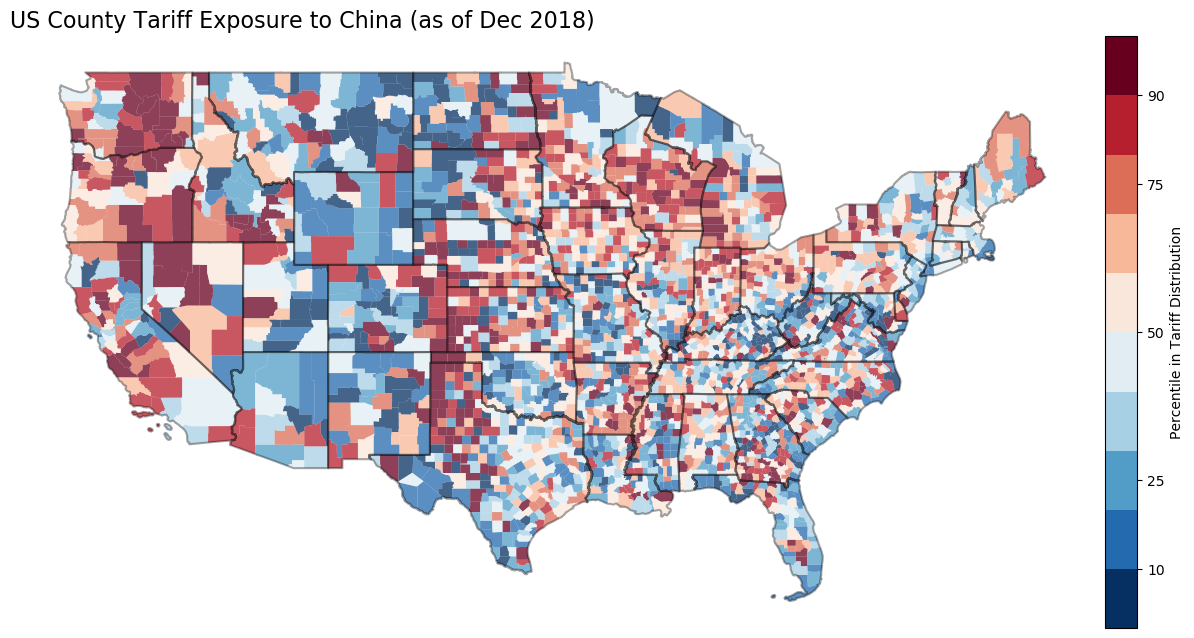

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize = (12,8))

plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

#################################################################################
# This is for the colorbar...

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)

#################################################################################
## This creates a discrete colorbar scheme...
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

N = 10

base = plt.cm.get_cmap("RdBu_r")

color_list = base(np.linspace(0, 1, N))

cmap_name = base.name + str(N)

dcmap =  base.from_list(cmap_name, color_list, N)

#################################################################################
# This is the normal mapping...

us_map.plot(column='q_tariff', ax = ax,
              # THIS IS NEW, it says color it based on this column
             cmap=dcmap, 
             alpha = 0.75,
             vmin=0, vmax=us_map.q_tariff.max())

#################################################################################
# This then alows me to generate and edit the colorbar....
# https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas

sm = plt.cm.ScalarMappable(cmap=dcmap)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.set_label('Percentile in Tariff Distribution')
cbr.set_alpha(0.15)

cbr.set_ticks([0.10, 0.25,0.50,0.75, 0.90])
cbr.set_ticklabels(["10","25","50","75","90"], update_ticks=True)

#################################################################################

state_map.geometry.boundary.plot(color=None, edgecolor='k', alpha = 0.35, ax = ax)

#################################################################################
# Then some final stuff to clean things up....

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

ax.set_title("US County Tariff Exposure to China (as of Dec 2018)", fontsize = 16, loc= "left" )

#ax.text(-127,23, "Source: US Census, BLS", fontsize = 8)

fig_path = "C:\\github\\expenditure_tradeshocks\\figures"

plt.savefig(fig_path +"\\us_china_exports_map.png", bbox_inches = "tight", dip = 1200)

plt.show()